# Attention module

In [10]:
#!pip install flash-attn


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
def debug_attention(name, Q, K, V, scores, masked_scores, attn_weights, output, tokens):
    Q, K, V = Q.squeeze(0), K.squeeze(0), V.squeeze(0)

    if scores is not None:
        scores = scores.squeeze(0)
    if masked_scores is not None:
        masked_scores = masked_scores.squeeze(0)
    attn_weights = attn_weights.squeeze(0)
    output = output.squeeze(0)

    print(f"\n--- {name} ---")
    print("Q:\n", Q)
    print("K:\n", K)
    print("V:\n", V)
    if scores is not None:
        print("Scores:\n", scores)
    if masked_scores is not None:
        print("Masked Scores:\n", masked_scores)
    print("Attention Weights:\n", attn_weights)
    print("Output:\n", output)

    def plot_heatmap(matrix, title):
        plt.figure(figsize=(6, 5))
        sns.heatmap(matrix.detach().numpy(), annot=True, cmap="YlGnBu",
                    xticklabels=tokens, yticklabels=tokens)
        plt.title(title)
        plt.xlabel("Key")
        plt.ylabel("Query")
        plt.show()

    if scores is not None:
        plot_heatmap(scores, f"{name} - Raw Scores")
    plot_heatmap(attn_weights, f"{name} - Attention Weights")


class SelfAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.qkv = nn.Linear(dim, dim * 3)

    def forward(self, x, tokens):
        Q, K, V = self.qkv(x).chunk(3, dim=-1)
        scores = Q @ K.transpose(-2, -1) / x.size(-1)**0.5
        mask = torch.triu(torch.ones_like(scores) * float("-inf"), diagonal=1)
        masked_scores = scores + mask
        attn_weights = F.softmax(masked_scores, dim=-1)
        output = attn_weights @ V

        debug_attention("Self-Attention", Q, K, V, scores, masked_scores, attn_weights, output, tokens)

        return attn_weights, output  # Trả về cả attn_weights và output


In [12]:
class MultiQueryAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.q = nn.Linear(dim, dim)
        self.kv = nn.Linear(dim, dim * 2)

    def forward(self, x, tokens):
        Q = self.q(x)
        K, V = self.kv(x).mean(dim=0).chunk(2, dim=-1)  # Shared KV
        K = K.unsqueeze(0).expand_as(Q)
        V = V.unsqueeze(0).expand_as(Q)
        scores = Q @ K.transpose(-2, -1) / x.size(-1)**0.5
        mask = torch.triu(torch.ones_like(scores) * float("-inf"), diagonal=1)
        masked_scores = scores + mask
        attn_weights = F.softmax(masked_scores, dim=-1)
        output = attn_weights @ V
        debug_attention("Multi-Query Attention", Q, K, V, scores, masked_scores, attn_weights, output, tokens)
        return output


In [13]:
class GroupedQueryAttention(nn.Module):
    def __init__(self, dim, num_groups=2):
        super().__init__()
        self.num_groups = num_groups
        self.qkv = nn.Linear(dim, dim * 3)

    def forward(self, x, tokens):
        Q, K, V = self.qkv(x).chunk(3, dim=-1)
        B, T, D = x.shape

        if T % self.num_groups != 0:
            raise ValueError(f"T ({T}) must be divisible by num_groups ({self.num_groups})")

        group_size = T // self.num_groups

        outputs = []
        all_attn_weights = []

        for g in range(self.num_groups):
            start = g * group_size
            end = (g + 1) * group_size

            # Trích Q, K, V theo group
            Q_g = Q[:, start:end, :]  # (B, group_size, D)
            K_g = K[:, start:end, :]  # (B, group_size, D)
            V_g = V[:, start:end, :]  # (B, group_size, D)

            # Tính attention trong group
            scores = Q_g @ K_g.transpose(-2, -1) / (D ** 0.5)  # (B, group_size, group_size)
            mask = torch.triu(torch.ones_like(scores) * float("-inf"), diagonal=1)
            masked_scores = scores + mask
            attn_weights = F.softmax(masked_scores, dim=-1)
            output = attn_weights @ V_g  # (B, group_size, D)

            outputs.append(output)
            all_attn_weights.append(attn_weights)

            # Debug từng nhóm riêng biệt
            debug_attention(f"GQA Group {g}", Q_g, K_g, V_g, scores, masked_scores, attn_weights, output, tokens[start:end])

        # Gộp lại kết quả từ các group
        final_output = torch.cat(outputs, dim=1)  # (B, T, D)

        # Gộp attention weights thành attention map đầy đủ
        full_attn = torch.zeros(B, T, T, device=x.device)
        for g in range(self.num_groups):
            start = g * group_size
            end = (g + 1) * group_size
            full_attn[:, start:end, start:end] = all_attn_weights[g]

        # Debug biểu đồ attention tổng thể
        debug_attention("GQA - Full Attention Map", Q, K, V, None, None, full_attn, final_output, tokens)

        return final_output


In [14]:
class FlashAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.qkv = nn.Linear(dim, dim * 3)
        self.out = nn.Linear(dim, dim)

    def forward(self, x, tokens):
        Q, K, V = self.qkv(x).chunk(3, dim=-1)
        D = Q.size(-1)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / D**0.5
        mask = torch.triu(torch.ones_like(scores) * float('-inf'), diagonal=1)
        masked_scores = scores + mask
        attn_weights = F.softmax(masked_scores, dim=-1)
        output = torch.matmul(attn_weights, V)
        output = self.out(output)

        debug_attention("Flash Attention", Q, K, V, scores, masked_scores, attn_weights, output, tokens)
        return output




--- Self-Attention ---
Q:
 tensor([[ 0.6412, -1.0908,  0.3226,  0.0817],
        [ 0.7423,  0.0496, -0.9262,  0.1135],
        [ 0.0249,  0.2473,  0.2382,  0.7843],
        [ 0.7846,  0.1125, -0.4329,  0.2523]], grad_fn=<SqueezeBackward1>)
K:
 tensor([[ 0.3359, -0.1020,  0.3749,  0.0995],
        [-1.3317,  0.3122, -0.2724, -0.8315],
        [ 0.0084, -0.4866, -0.8387, -0.0173],
        [-1.0980, -0.2335, -1.5515, -0.0639]], grad_fn=<SqueezeBackward1>)
V:
 tensor([[-0.0073, -0.3518,  0.7640,  0.6995],
        [ 0.2363, -0.2443,  0.0906,  0.1536],
        [ 0.6782, -0.5265,  0.9316, -0.1473],
        [ 0.4972, -0.2398,  1.3758,  0.5143]], grad_fn=<SqueezeBackward1>)
Scores:
 tensor([[ 0.2278, -0.6751,  0.1321, -0.4775],
        [-0.0459, -0.4076,  0.3785,  0.3016],
        [ 0.0753, -0.3365, -0.1668, -0.2524],
        [ 0.0574, -0.5508,  0.1553, -0.1161]], grad_fn=<SqueezeBackward1>)
Masked Scores:
 tensor([[ 0.2278,    -inf,    -inf,    -inf],
        [-0.0459, -0.4076,    -inf,    -i

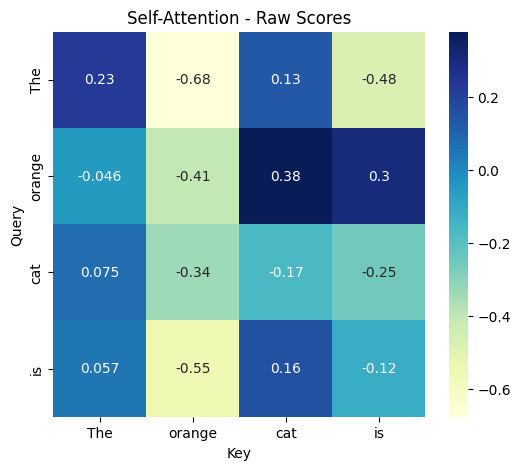

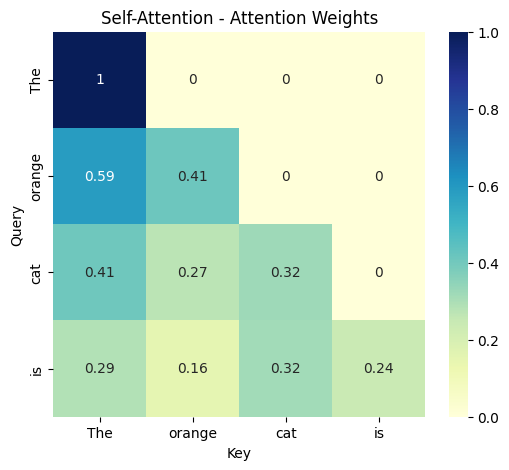


--- Multi-Query Attention ---
Q:
 tensor([[ 1.2719,  0.6417, -0.2719, -0.0020],
        [-0.1516, -0.3603, -0.3517,  0.0495],
        [ 0.5240,  0.2688,  0.0412, -0.0999],
        [ 1.0957, -0.6967, -1.2173, -0.0709]], grad_fn=<SqueezeBackward1>)
K:
 tensor([[-5.3416e-01,  7.8560e-01, -1.7580e-01,  1.4297e+00],
        [ 1.2976e-02, -8.2457e-02,  1.5883e-01, -3.1826e-01],
        [ 2.5913e-04,  4.3727e-01,  3.6065e-01,  5.6302e-01],
        [-2.9045e-01, -9.7495e-03,  7.6382e-01, -1.4716e-01]],
       grad_fn=<SqueezeBackward1>)
V:
 tensor([[ 0.1034, -0.3468,  0.5429, -0.0143],
        [ 0.8170,  0.1223, -0.4867,  0.1928],
        [ 0.3457, -0.2336,  0.4685, -0.0312],
        [ 0.6981, -0.3286, -0.8466, -0.1080]], grad_fn=<SqueezeBackward1>)
Scores:
 tensor([[-0.0652, -0.0395,  0.0909, -0.2915],
        [-0.0348, -0.0219, -0.1283, -0.1142],
        [-0.1094,  0.0115,  0.0382, -0.0543],
        [-0.5100, -0.0496, -0.3917, -0.6154]], grad_fn=<SqueezeBackward1>)
Masked Scores:
 tensor([[

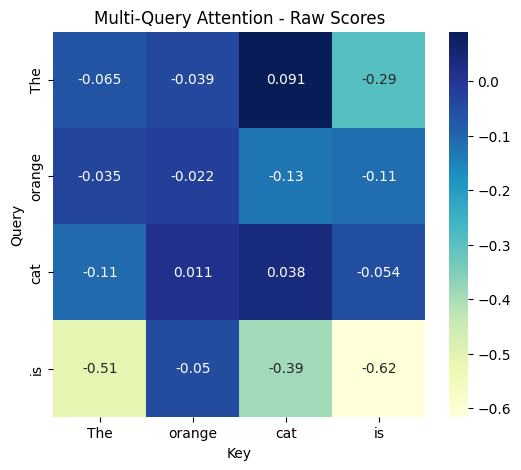

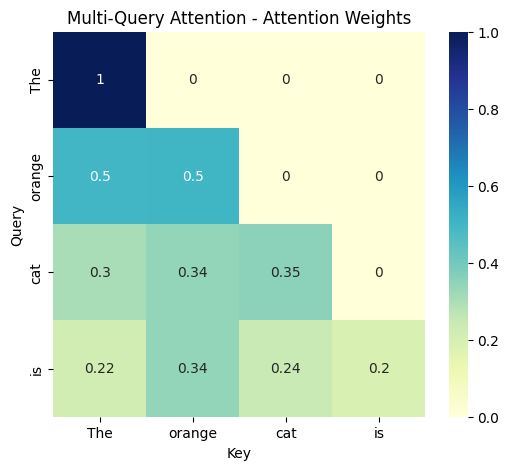


--- GQA Group 0 ---
Q:
 tensor([[-0.1917, -0.5878, -0.3485,  0.9482],
        [-0.4781,  0.3830,  0.3185, -0.2182]], grad_fn=<SqueezeBackward1>)
K:
 tensor([[-0.2660, -0.9153, -0.6667, -1.2657],
        [ 0.7654,  0.2710, -0.8346, -0.1055]], grad_fn=<SqueezeBackward1>)
V:
 tensor([[ 0.6249,  0.3508,  0.1519, -0.9470],
        [-0.8009, -0.0770, -0.1751, -0.9795]], grad_fn=<SqueezeBackward1>)
Scores:
 tensor([[-0.1894, -0.0576],
        [-0.0798, -0.2524]], grad_fn=<SqueezeBackward1>)
Masked Scores:
 tensor([[-0.1894,    -inf],
        [-0.0798, -0.2524]], grad_fn=<SqueezeBackward1>)
Attention Weights:
 tensor([[1.0000, 0.0000],
        [0.5431, 0.4569]], grad_fn=<SqueezeBackward1>)
Output:
 tensor([[ 0.6249,  0.3508,  0.1519, -0.9470],
        [-0.0266,  0.1553,  0.0025, -0.9618]], grad_fn=<SqueezeBackward1>)


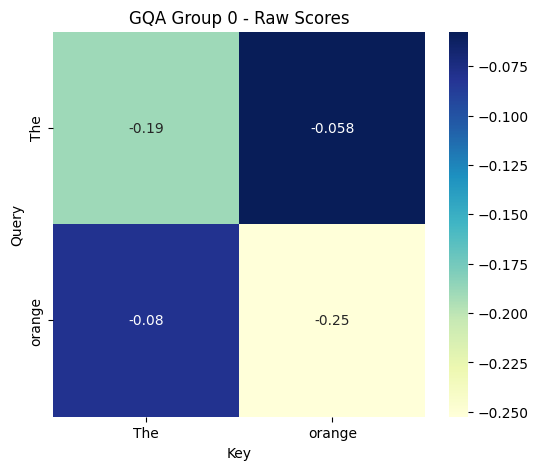

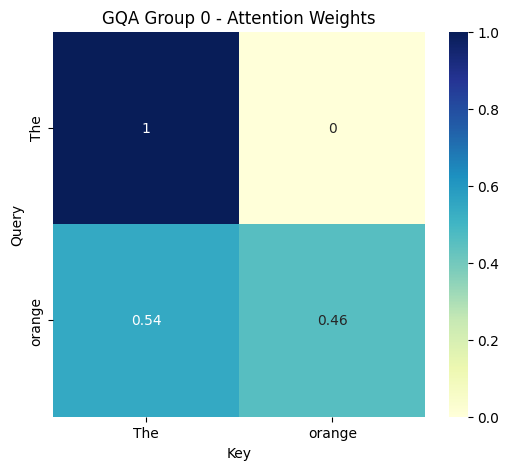


--- GQA Group 1 ---
Q:
 tensor([[-0.1777,  0.7002,  0.5978, -0.0945],
        [ 0.4388,  0.0779,  0.3181, -0.7954]], grad_fn=<SqueezeBackward1>)
K:
 tensor([[ 0.6021, -0.2428, -0.1855,  0.2392],
        [ 0.9206,  0.7489, -0.4016, -0.0422]], grad_fn=<SqueezeBackward1>)
V:
 tensor([[ 0.4057, -0.7224, -0.8593, -0.2114],
        [ 0.9256, -0.2593, -1.4519, -1.1755]], grad_fn=<SqueezeBackward1>)
Scores:
 tensor([[-0.2053,  0.0624],
        [-0.0020,  0.1841]], grad_fn=<SqueezeBackward1>)
Masked Scores:
 tensor([[-0.2053,    -inf],
        [-0.0020,  0.1841]], grad_fn=<SqueezeBackward1>)
Attention Weights:
 tensor([[1.0000, 0.0000],
        [0.4536, 0.5464]], grad_fn=<SqueezeBackward1>)
Output:
 tensor([[ 0.4057, -0.7224, -0.8593, -0.2114],
        [ 0.6897, -0.4694, -1.1831, -0.7382]], grad_fn=<SqueezeBackward1>)


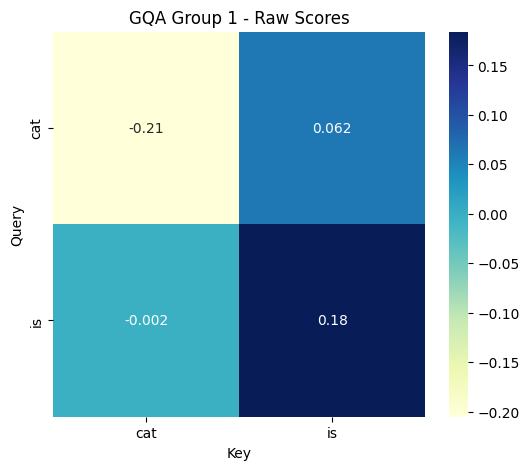

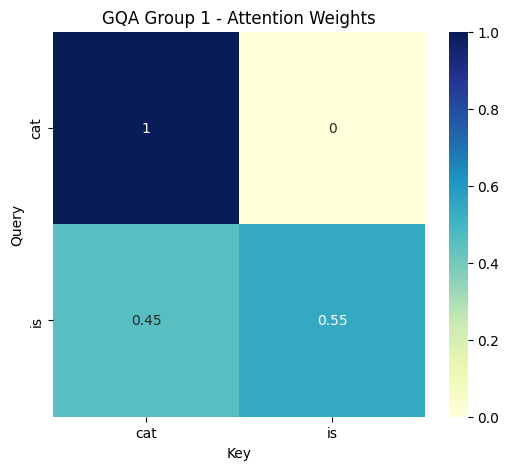


--- GQA - Full Attention Map ---
Q:
 tensor([[-0.1917, -0.5878, -0.3485,  0.9482],
        [-0.4781,  0.3830,  0.3185, -0.2182],
        [-0.1777,  0.7002,  0.5978, -0.0945],
        [ 0.4388,  0.0779,  0.3181, -0.7954]], grad_fn=<SqueezeBackward1>)
K:
 tensor([[-0.2660, -0.9153, -0.6667, -1.2657],
        [ 0.7654,  0.2710, -0.8346, -0.1055],
        [ 0.6021, -0.2428, -0.1855,  0.2392],
        [ 0.9206,  0.7489, -0.4016, -0.0422]], grad_fn=<SqueezeBackward1>)
V:
 tensor([[ 0.6249,  0.3508,  0.1519, -0.9470],
        [-0.8009, -0.0770, -0.1751, -0.9795],
        [ 0.4057, -0.7224, -0.8593, -0.2114],
        [ 0.9256, -0.2593, -1.4519, -1.1755]], grad_fn=<SqueezeBackward1>)
Attention Weights:
 tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5431, 0.4569, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.4536, 0.5464]], grad_fn=<SqueezeBackward1>)
Output:
 tensor([[ 0.6249,  0.3508,  0.1519, -0.9470],
        [-0.0266,  0.1553,  0.0025, -0.9618

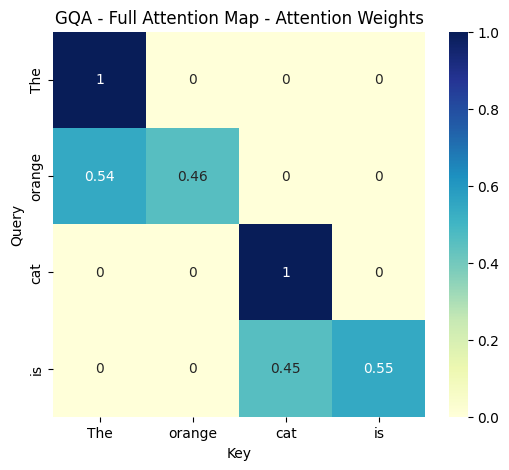


--- Flash Attention ---
Q:
 tensor([[ 0.1062, -1.1566, -0.0867,  0.2010],
        [ 0.5764, -0.2510, -0.3854, -0.0031],
        [-0.1071,  0.1561, -0.4563,  0.5834],
        [ 0.1128, -1.0008, -0.5831, -0.0952]], grad_fn=<SqueezeBackward1>)
K:
 tensor([[ 0.7047, -0.8012, -1.2185,  0.1661],
        [-0.3607,  0.5273, -0.1267, -0.0289],
        [ 0.6535, -0.2456, -0.2304, -0.5716],
        [-0.6333, -0.0405, -0.5503, -0.1975]], grad_fn=<SqueezeBackward1>)
V:
 tensor([[-0.6750, -0.4776, -0.1746,  0.2856],
        [-0.1392,  0.5114,  0.5373,  0.7915],
        [-0.2635, -0.4072,  0.3517, -0.1201],
        [ 0.0298, -0.2588,  0.2524,  0.2124]], grad_fn=<SqueezeBackward1>)
Scores:
 tensor([[ 0.5702, -0.3215,  0.1292, -0.0062],
        [ 0.5382, -0.1457,  0.2645, -0.0711],
        [ 0.2262,  0.0809, -0.1683,  0.0987],
        [ 0.7880, -0.2459,  0.2541,  0.1544]], grad_fn=<SqueezeBackward1>)
Masked Scores:
 tensor([[ 0.5702,    -inf,    -inf,    -inf],
        [ 0.5382, -0.1457,    -inf,    -

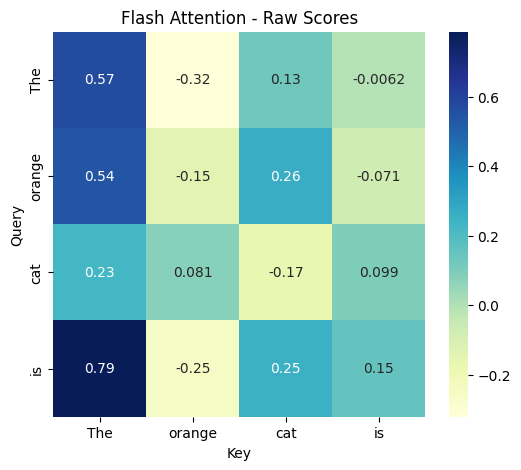

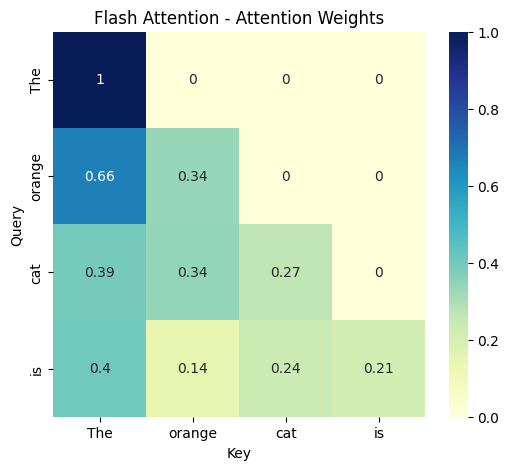

In [18]:
# Tạo đầu vào ví dụ
tokens = ["The", "orange", "cat", "is"]
x = torch.randn(1, len(tokens), 4)  # Batch size = 1, sequence length = 5, embedding dim = 4

# Kiểm tra Self-Attention
self_attn = SelfAttention(dim=4)
output = self_attn(x, tokens)

# Kiểm tra Multi-Query Attention
mqa = MultiQueryAttention(dim=4)
output = mqa(x, tokens)

# Kiểm tra Grouped-Query Attention
gqa = GroupedQueryAttention(dim=4, num_groups=2)
output = gqa(x, tokens)

# Kiểm tra Flash Attention
flash_attn = FlashAttention(dim=4)
output = flash_attn(x, tokens)
